# Integrate a nondimensional form of the equation

This notebook contains the code necessary to call the LSODA integrator on a reparametrized form of the reaction diffusion equation (see the main notebook *main_rxndiff_solver.ipynb* for details). For this notebook, time has been rescaled so that the ugly $t^{1-\alpha}$ term now appears on the reaction portion as $t^{\frac{1}{\alpha} - 1}$. A few other standard rescalings have been performed as well, such that the equation that is being solved looks like:

$$\dot \phi = \hat H_{diff} \phi - \gamma t^{\frac{1}{\alpha} - 1} \mathcal H(d - r) \phi $$

where $H_{diff}$ is the standard spatial diffusion operator in an harmonic potential (the terms from this are writte nout explicitly in *main_rxndiff_solver.ipynb*). \mathcal H is a unit step. This equation is derived by taking our original diffusion equation and performing the substitution $t \leftarrow D t^\alpha$ and $\gamma \leftarrow \dfrac{\gamma}{(D^{1/\alpha} \alpha)}$

This integrator appears to fail at early times due to an instability that propagates from the edge of the reaction zone. This is different than the behavior of the standard, dimensional form of the reaction-diffusion equation, which appears to fail due to an instability that propagates from the origin

*If you are current reading an HTML file, then you are looking at a static snapshot of the .ipynb version of this file.*

#### Preamble (Import necessary packages)

In [1]:
# import matplotlib
# matplotlib.use( "agg" )
%pylab inline

import plt_fmt

# from numba import jit

from fig_annotate import *

from diffusion_integrator_funcs import *
# from frac_brown import *

from brownian_integrator import *

Populating the interactive namespace from numpy and matplotlib


## Initialize parameter values and run an integration

In [21]:
from scipy.integrate import ode

## pick parameter values
params = dict()

# alpha less than one
params['ALPHA']= .5
# width of reactive well
params['WELL_DIAM'] = 1
# width of overall potential well. smaller this is, the stronger the forcing
params['POT_DIAM'] = 100
params['KAPPA'] = 1e3
params['DCOEFF'] = 1.0 # this has been dimensionalized out so it doesn't matter



ACTUAL_LENGTH = 10*params['POT_DIAM']

# set integrator settings
settings = dict()

# TIME
# remember that these have been rescaled to unusual units
time_pts = 1e6
start_time = 0.0
stop_time = 1e3
times = linspace(start_time, stop_time, time_pts)
dt = times[2]-times[1]
times = times+dt
settings['times'] = times

# SPACE
space_pts = 100
space = linspace(0.0, ACTUAL_LENGTH, space_pts)
dx = space[2] - space[1]
space = space+dx
# settings['dx'] = dx
settings['space'] = space

# initial conditions
y0 = ones(space_pts)

# r = ode(nxt_step, jacob).set_integrator('vode', method='bdf', with_jacobian=True)
r = ode(nxt_step, radiff_timeop_nondim).set_integrator('lsoda', with_jacobian=True)
r.set_initial_value(y0, times[0])

r.set_f_params([settings, params])
r.set_jac_params([settings, params])

t1 = times[-1]
sol = list()
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    sol.append(r.y)

sol = array(real(sol)).T


# now multiply through by the equilibrium distribution
gauss = eq_dist(space, params['POT_DIAM'])
gauss = gauss[:, None]
sol = sol*gauss


## Make plots of solutions

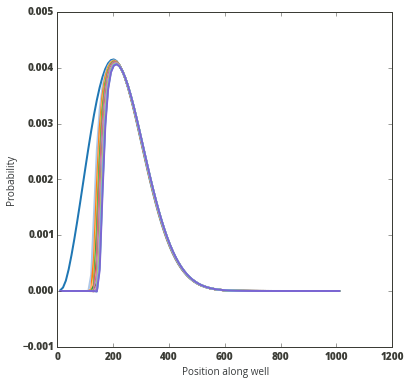

In [22]:
# plot time slices
figure()
solrange = len(sol[0,:])
num_slices = 20
hold(True)
slice_range = floor(solrange/num_slices)
for ii in range(num_slices):
    plot(space, sol[:,ii*slice_range])
plot(space, sol[:,-1])
# ylim([0,10])
rcParams['font.family']='Open Sans'
xlabel("Position along well")
ylabel("Probability")
namestr = 'alpha_' + str(params['ALPHA']) + '__diffu_' + str(params['DCOEFF'])+'__kappa_' +\
str(params['KAPPA'])+'__reacdiam_' +str(params['WELL_DIAM'])+'__potdiam_' + str(params['POT_DIAM'])
# savefig(namestr+'.pdf')


# figure() 
# total_conc = sum(sol, axis = 0)
# plot(times, total_conc[:-1])
# ylabel("Total count")
# xlabel("time")

Right now, this version of the system seems fussier than the version with the power-law time in the normal place. Curiously, the instability appears to propagate from the edge of the reaction zone, rather than the origin.

## Calculate survial probability timescales

This operation is described in detail in the other notebook, **main_rxndiff_solver.ipynb**

In [19]:
## pick parameter values


def timescale_vs_asquared_nondim(well_diams, params, settings, save_full_sol=False):
    '''
    Estimate the characteristic timescale of the reaction diffusion system 
    as a function of the well diameter. This code does not save the full 
    solution for memory reasons.
    
    INPUTS
    ------
    
    well_diams : array
        The different potential well widths at which to run simulations
    
    params : dict()
        All parameters values to use in the integration
        
   settings : dict()
        All of the settings for the integrator
        
        
    RETURNS
    -------
    
    outs : array
        Survival probability traces for each value in well_diams
    
    '''
    
    # make a defensive copy
    params = params.copy()
    settings = settings.copy()

    allsol = list()
    all_timesums = list()
    ct = 0

    for diam in well_diams:
        
        params['POT_DIAM'] = diam
        space_pts = 100
        ACTUAL_LENGTH = 10*params['POT_DIAM']
#         ACTUAL_LENGTH = .5
        dx = ACTUAL_LENGTH/space_pts
        space = linspace(0.0, ACTUAL_LENGTH, space_pts)
        space = space+dx
    
        settings['space'] = space
        
        # set initial equilibrium conditions
        y0 = ones(space_pts)
        
        # have to re-intialize because r is a generator expression
        r = ode(nxt_step, radiff_timeop_nondim).set_integrator('lsoda', with_jacobian=True)
        r.set_initial_value(y0, times[0])
        r.set_f_params([settings, params])
        r.set_jac_params([settings, params])
        t1 = times[-1]

        sol = list()
        while r.successful() and r.t < t1:
            r.integrate(r.t+dt)
            sol.append(r.y)
        sol = array(real(sol)).T

        gauss = eq_dist(space, params['POT_DIAM'])
        gauss = gauss[:, None]
        sol = sol*gauss
        
#         gauss = (1/sqrt(2*pi*params['POT_DIAM']**2))*exp(-space**2/(4*params['POT_DIAM']**2))
#         gauss = gauss[:, None]
#         sol = sol*gauss
#         radpart = 4*pi*(space**2)
#         radpart = radpart[:, None]
#         sol = radpart*sol


        # integrate out space
        timesum = dx*sum(sol, axis = 0)
        all_timesums.append( timesum )

        if save_full_sol:
            allsol.append( sol )
        
        # report on progress
        nn = len(well_diams)
        nnind = floor(nn/5)
        ct = mod(ct, nnind)
        ct += 1
        if ct==1: print (diam)
    
    outs = array(all_timesums)
    if save_full_sol:
        return [allsol, outs]
    else:
        return outs



def timescale_vs_asquared_vs_kappa(well_diams, kvals, params, settings):
    
    params = params.copy()
    outs = list()
    times = settings['times']
    dt = times[2] - times[1]
    
    for kval in kvals:
        params['KAPPA'] = kval
        tva = timescale_vs_asquared(well_diams, params, settings)
        outs.append( dt*sum(tva, axis=1) )
        
    return outs
        

def timescale_vs_asquared_vs_rxndiam(well_diams, rxn_diam_vals, params, settings):
    
    params = params.copy()
    outs = list()
    times = settings['times']
    dt = times[2] - times[1]
    
    for rxn_diam in rxn_diam_vals:
        params['WELL_DIAM'] = rxn_diam
        tva = timescale_vs_asquared(well_diams, params, settings)
        outs.append( dt*sum(tva, axis=1) )
        
    return outs

In [31]:
min_a_val = .001
max_a_val = .1

min_a_val = 1
max_a_val = 100
a_npts = 5


well_diams = expspace(min_a_val, max_a_val, a_npts)

out = timescale_vs_asquared_nondim(well_diams, params, settings, save_full_sol=False)


# plot the results
loglog(well_diams**2, dt*sum(out, axis=1),'.',markersize=20)
ylabel('Survival time')
xlabel('a^2 (proportional to molecular weight)')


# Why is this exploding?

1.0


KeyboardInterrupt: 